In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Alunos:
# Pablo Irineu de Souza – 202211152
# Paulo Ryan Garani Salgado – 202210959


# Configuração de dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # << Se você quiser forçar que seja em CPU!
print(f"Usando dispositivo: {device}")

## 1. Download e Preparação do Dataset MNIST
def carregar_dados():
    """
    Carrega os datasets MNIST de treino e teste.

    Retorna:
        train_loader: DataLoader para dados de treino
        test_loader: DataLoader para dados de teste
    """
    # Transformações aplicadas nas imagens
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converte para tensor
        transforms.Normalize((0.1307,), (0.3081,))  # Normaliza os pixels
    ])

    # Download dos datasets
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Cria os DataLoaders para carregar os dados em batches
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1000,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader



Usando dispositivo: cpu


In [7]:
## 2. Definição da Arquitetura da Rede Neural
class CNN_MNIST(nn.Module):
    """
    Define uma rede neural convolucional para classificação do MNIST.

    Arquitetura:
    - Camada convolucional 1: 1 canal de entrada, 32 canais de saída, kernel 3x3
    - Camada convolucional 2: 32 canais de entrada, 64 canais de saída, kernel 3x3
    - Camada fully connected 1: 1600 neurônios de entrada, 128 de saída
    - Camada fully connected 2: 128 neurônios de entrada, 10 de saída (classes)
    """
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # Repare nas duas camadas completamente conectadas ao final do modelo!!:
        self.fc1 = nn.Linear(64*7*7, 128)  # 64 canais * 7x7 imagem após pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Primeira camada convolucional + ReLU
        x = self.conv1(x)
        x = nn.functional.relu(x)

        # Pooling máximo para reduzir dimensão
        x = nn.functional.max_pool2d(x, 2)

        # Segunda camada convolucional + ReLU
        x = self.conv2(x)
        x = nn.functional.relu(x)

        # Pooling máximo para reduzir dimensão
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Achata o tensor para a camada fully connected
        x = torch.flatten(x, 1)

        # Primeira camada fully connected + ReLU
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)

        # Camada de saída
        x = self.fc2(x)

        return nn.functional.log_softmax(x, dim=1)


In [8]:
## 3. Funções de Treino e Teste
def treinar(modelo, dispositivo, train_loader, optimizer, epoch):
    """
    Executa uma época de treinamento do modelo.

    Args:
        modelo: Modelo CNN a ser treinado
        dispositivo: Dispositivo onde os cálculos serão feitos (CPU/GPU)
        train_loader: DataLoader com dados de treino
        optimizer: Otimizador para ajuste dos pesos
        epoch: Número da época atual

    Retorna:
        loss_medio: Loss médio da época
        acuracia: Acurácia do modelo nos dados de treino
    """
    modelo.train()  # Modo treino
    loss_total = 0
    corretos = 0

    for batch_idx, (dados, alvos) in enumerate(train_loader):
        dados, alvos = dados.to(dispositivo), alvos.to(dispositivo)

        # Zera os gradientes
        optimizer.zero_grad()

        # Forward pass
        output = modelo(dados)

        # Calcula o loss
        loss = nn.functional.nll_loss(output, alvos)

        # Backward pass
        loss.backward()

        # Atualiza os pesos
        optimizer.step()

        # Acumula estatísticas
        loss_total += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        corretos += pred.eq(alvos.view_as(pred)).sum().item()

    # Calcula médias
    tamanho_dataset = len(train_loader.dataset)
    loss_medio = loss_total / len(train_loader)
    acuracia = 100. * corretos / tamanho_dataset

    print(f'Treino - Época {epoch}: Loss médio: {loss_medio:.4f}, Acurácia: {corretos}/{tamanho_dataset} ({acuracia:.2f}%)')

    return loss_medio, acuracia

def testar(modelo, dispositivo, test_loader):
    """
    Avalia o modelo nos dados de teste.

    Args:
        modelo: Modelo CNN a ser avaliado
        dispositivo: Dispositivo onde os cálculos serão feitos (CPU/GPU)
        test_loader: DataLoader com dados de teste

    Retorna:
        loss_medio: Loss médio no conjunto de teste
        acuracia: Acurácia do modelo nos dados de teste
    """
    modelo.eval()  # Modo avaliação
    loss_total = 0
    corretos = 0

    with torch.no_grad():  # Desabilita cálculo de gradientes
        for dados, alvos in test_loader:
            dados, alvos = dados.to(dispositivo), alvos.to(dispositivo)

            # Forward pass
            output = modelo(dados)

            # Calcula o loss
            loss_total += nn.functional.nll_loss(output, alvos, reduction='sum').item()

            # Calcula acertos
            pred = output.argmax(dim=1, keepdim=True)
            corretos += pred.eq(alvos.view_as(pred)).sum().item()

    # Calcula médias
    tamanho_dataset = len(test_loader.dataset)
    loss_medio = loss_total / tamanho_dataset
    acuracia = 100. * corretos / tamanho_dataset

    print(f'Teste - Loss médio: {loss_medio:.4f}, Acurácia: {corretos}/{tamanho_dataset} ({acuracia:.2f}%)')

    return loss_medio, acuracia



In [9]:
## 4. Treinamento com Early Stopping
def treinamento_com_early_stopping(modelo, dispositivo, train_loader, test_loader, max_epocas=20):
    """
    Executa o treinamento do modelo com early stopping para evitar overfitting.

    Args:
        modelo: Modelo CNN a ser treinado
        dispositivo: Dispositivo onde os cálculos serão feitos (CPU/GPU)
        train_loader: DataLoader com dados de treino
        test_loader: DataLoader com dados de teste
        max_epocas: Número máximo de épocas de treino

    Retorna:
        historico: Dicionário com histórico de loss e acurácia
    """
    optimizer = optim.Adam(modelo.parameters(), lr=0.0005)

    # Inicializa histórico
    historico = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'melhor_loss': float('inf'),
        'epocas_sem_melhoria': 0,
        'melhor_epoca': 0
    }

    for epoch in range(1, max_epocas + 1):
        # Executa uma época de treino
        train_loss, train_acc = treinar(modelo, dispositivo, train_loader, optimizer, epoch)

        # Avalia no conjunto de teste
        test_loss, test_acc = testar(modelo, dispositivo, test_loader)

        # Armazena no histórico
        historico['train_loss'].append(train_loss)
        historico['train_acc'].append(train_acc)
        historico['test_loss'].append(test_loss)
        historico['test_acc'].append(test_acc)

        # Verifica early stopping
        if test_loss < historico['melhor_loss']:
            historico['melhor_loss'] = test_loss
            historico['epocas_sem_melhoria'] = 0
            historico['melhor_epoca'] = epoch
            # Salva o melhor modelo
            torch.save(modelo.state_dict(), 'melhor_modelo_mnist.pt')
        else:
            historico['epocas_sem_melhoria'] += 1
            if historico['epocas_sem_melhoria'] >= 5:  # Paciência de 5 épocas
                print(f"\nEarly stopping na época {epoch}! O erro de teste não melhorou desde a época {historico['melhor_epoca']}.")
                break

    # Carrega o melhor modelo antes do overfitting
    modelo.load_state_dict(torch.load('melhor_modelo_mnist.pt'))

    return historico

## 5. Visualização dos Resultados
def plotar_resultados(historico):
    """
    Plota gráficos de loss e acurácia durante o treinamento.

    Args:
        historico: Dicionário com histórico de treinamento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Gráfico de Loss
    ax1.plot(historico['train_loss'], label='Treino')
    ax1.plot(historico['test_loss'], label='Teste')
    ax1.set_title('Loss durante o Treinamento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Gráfico de Acurácia
    ax2.plot(historico['train_acc'], label='Treino')
    ax2.plot(historico['test_acc'], label='Teste')
    ax2.set_title('Acurácia durante o Treinamento')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()




Iniciando treinamento...
--------------------------------------------------
Treino - Época 1: Loss médio: 0.3234, Acurácia: 54028/60000 (90.05%)
Teste - Loss médio: 0.0693, Acurácia: 9772/10000 (97.72%)
Treino - Época 2: Loss médio: 0.1087, Acurácia: 58061/60000 (96.77%)
Teste - Loss médio: 0.0491, Acurácia: 9834/10000 (98.34%)
Treino - Época 3: Loss médio: 0.0818, Acurácia: 58607/60000 (97.68%)
Teste - Loss médio: 0.0393, Acurácia: 9871/10000 (98.71%)
Treino - Época 4: Loss médio: 0.0682, Acurácia: 58803/60000 (98.00%)
Teste - Loss médio: 0.0363, Acurácia: 9877/10000 (98.77%)
Treino - Época 5: Loss médio: 0.0582, Acurácia: 58952/60000 (98.25%)
Teste - Loss médio: 0.0295, Acurácia: 9901/10000 (99.01%)
Treino - Época 6: Loss médio: 0.0515, Acurácia: 59044/60000 (98.41%)
Teste - Loss médio: 0.0278, Acurácia: 9905/10000 (99.05%)
Treino - Época 7: Loss médio: 0.0475, Acurácia: 59134/60000 (98.56%)
Teste - Loss médio: 0.0272, Acurácia: 9913/10000 (99.13%)
Treino - Época 8: Loss médio: 0.04

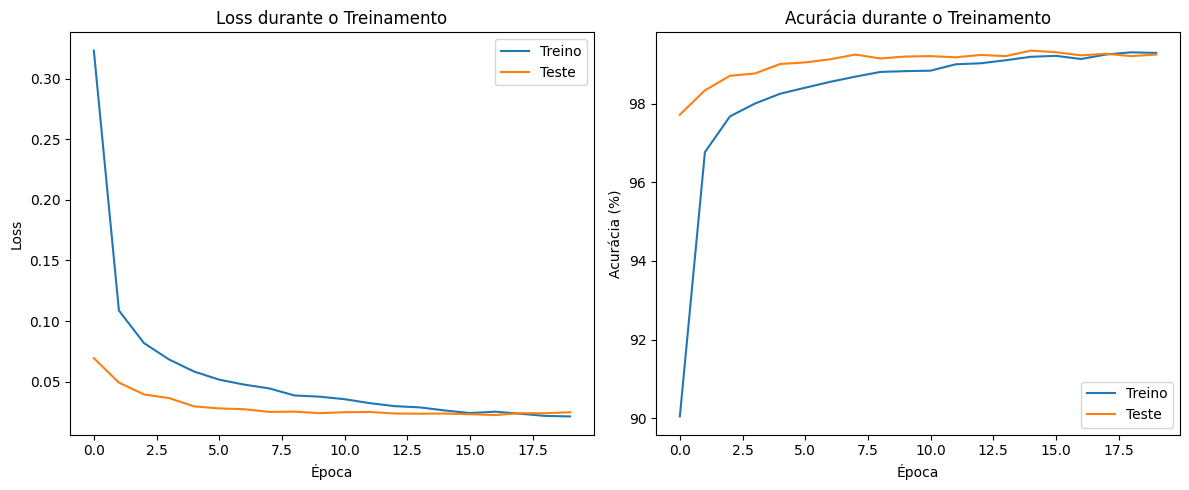


Exemplos de classificação:


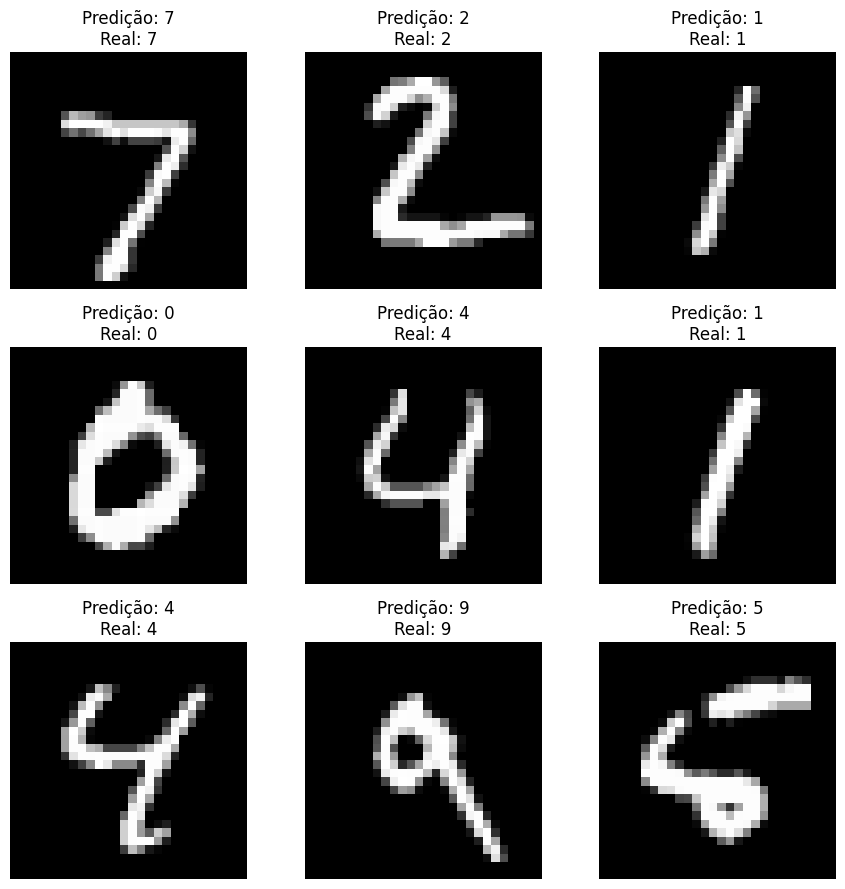

In [10]:
## 6. Exemplo de Uso do Modelo Treinado
def exemplo_uso(modelo, dispositivo, test_loader):
    """
    Mostra um exemplo de classificação usando o modelo treinado.

    Args:
        modelo: Modelo CNN treinado
        dispositivo: Dispositivo onde os cálculos serão feitos (CPU/GPU)
        test_loader: DataLoader com dados de teste
    """
    # Pega um batch de exemplos de teste
    data_iter = iter(test_loader)
    dados, alvos = next(data_iter)

    # Seleciona apenas 9 exemplos para visualização
    dados = dados[:9]
    alvos = alvos[:9]

    dados, alvos = dados.to(dispositivo), alvos.to(dispositivo)

    # Faz a predição
    modelo.eval()
    with torch.no_grad():
        output = modelo(dados)

    # Pega as predições
    preds = output.argmax(dim=1)

    # Mostra os exemplos
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axes.flat):
        img = dados[i].cpu().numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Predição: {preds[i].item()}\nReal: {alvos[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## 7. Fluxo Principal
def main():
    # Carrega os dados
    train_loader, test_loader = carregar_dados()

    # Cria o modelo e envia para o dispositivo (GPU/CPU)
    modelo = CNN_MNIST().to(device)

    print("\nIniciando treinamento...")
    print("--------------------------------------------------")

    # Executa o treinamento
    historico = treinamento_com_early_stopping(
        modelo,
        device,
        train_loader,
        test_loader,
        max_epocas=20
    )

    # Plota os resultados
    plotar_resultados(historico)

    # Mostra um exemplo de uso
    print("\nExemplos de classificação:")
    exemplo_uso(modelo, device, test_loader)

if __name__ == '__main__':
    main()
